In [ ]:
# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
from glob import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/home/brais/Documents/Next/IC/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Tue May 23 20:06:50 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-23 20:06:53


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Lifetime evolution

In [76]:
# Getter configuration changes:

c1 = datetime.datetime.strptime('2017-05-17 00:00:0', '%Y-%m-%d %H:%M:%S')  #from no circulation to almost no circulation
c2 = datetime.datetime.strptime('2017-05-18 17:05:0', '%Y-%m-%d %H:%M:%S')  #from almost no circulation to both cold getters
c3 = datetime.datetime.strptime('2017-05-19 14:00:0', '%Y-%m-%d %H:%M:%S')  #from both cold getters to only new one
c4 = datetime.datetime.strptime('2017-05-22 19:30:0', '%Y-%m-%d %H:%M:%S')  #from new cold getter to both new cold and old one

changes = [c1, c2, c3, c4]

In [83]:
runs = [3988, 3998, 4002, 4021, 4027, 4029, 4035, 4050, 4051, 4052,4054, 4055, 4059, 4062]
lfts = [324.59538339,  404.24495666,  537.97792931, 448.83467264, 
        556.71275205 ,  564.5237774 ,  537.66806862,  564.66179776, 599.60725061, 552.66614970951889, 612.9 ,
        679.99603157 ,  688.84559579,  696.45223789]
elft = [5.56803161,   6.23515846,   7.62450068,
         6.16327547,  10.19182985,   4.0780064 ,   8.27618075,
         9.75576244,   7.12755768,  9.4570424 ,  12.72549722, 5.29102523,  20.4569329 ,   8.05596304]
time = [ 1494938995.642,
 1495090771.007,
 1495100812.9549999,
 1495130594.4750001,
 1495184193.4750001,
 1495221271.5450001,
 1495275426.859,
 1495317309.809,
 1495362000.4190001,
 1495392813.332,
 1495443303.825,      
 1495476276.428,
 1495529671.013,
 1495549466.6760001]

runs = np.array(runs)
lfts = np.array(lfts)
elft = np.array(elft)
time = np.array(time)
date = [datetime.datetime.fromtimestamp(ti).strftime('%Y-%m-%d %H:%M:%S') for ti in time]
date = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in date]

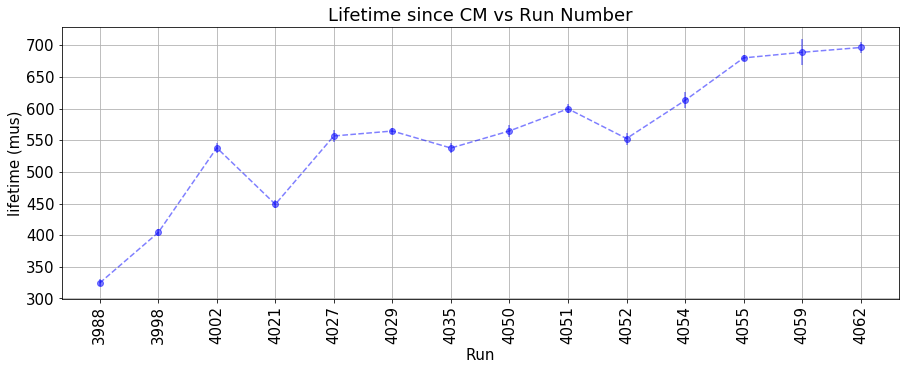

In [84]:
plt.figure(figsize=(15,5))
#plt.plot(times, lifetimes)
plt.errorbar(range(len(lfts)), lfts, yerr=elft, linestyle='--', fmt='o', c='blue', alpha=.5)
plt.xticks(range(len(lfts)), runs, rotation='vertical')
plt.grid(True)
plt.title('Lifetime since CM vs Run Number')
plt.xlabel('Run')
plt.ylabel('lifetime (mus)')
plt.show()



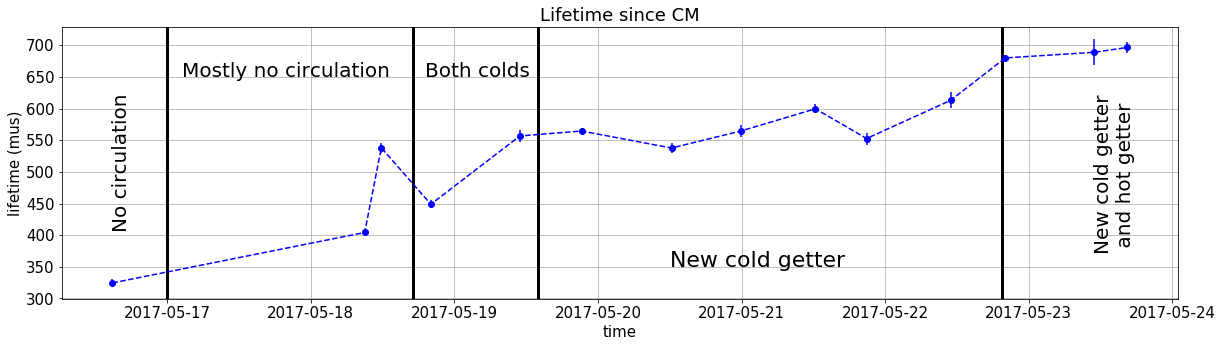

In [85]:
plt.figure(figsize=(20,5))
#plt.plot(times, lifetimes)
plt.errorbar(date, lfts, yerr=elft, linestyle='--', fmt='o', c='blue')
plt.grid(True)
plt.title('Lifetime since CM')
plt.xlabel('time')
plt.ylabel('lifetime (mus)')

for ci  in changes:
    plt.axvline(x=ci, color='k', linewidth=3)

plt.text(date[0],600,'No circulation', fontsize=20,rotation='vertical')
auxd = datetime.datetime.strptime('2017-05-17 02:30:0', '%Y-%m-%d %H:%M:%S')
plt.text(auxd,650,'Mostly no circulation', fontsize=20,rotation='horizontal')
auxd = datetime.datetime.strptime('2017-05-18 19:00:0', '%Y-%m-%d %H:%M:%S')
plt.text(auxd,650,'Both colds', fontsize=20,rotation='horizontal')
auxd = datetime.datetime.strptime('2017-05-20 12:00:0', '%Y-%m-%d %H:%M:%S')
plt.text(auxd,350,'New cold getter', fontsize=22,rotation='horizontal')
#auxd = datetime.datetime.strptime('2017-05-20 12:00:0', '%Y-%m-%d %H:%M:%S')
plt.text(date[-2],575.0,'New cold getter \n and hot getter', fontsize=20,rotation='vertical')

In [79]:
elft

array([  5.56803161,   6.23515846,   7.62450068,   6.16327547,
        10.19182985,   4.0780064 ,   8.27618075,   9.75576244,
         7.12755768,   5.29102523,  20.4569329 ,   8.05596304])